In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('CyberBullying Comments Dataset.csv')

In [4]:
df.head()

Text  CB_Label
0  damn there is someones nana up here at beach w...         0
1  no kidding! dick clark was a corpse mechanical...         0
2  i read an article on jobros and thought damn w...         0
3  I got one fucking day of sprinkles and now it'...         0
4  I was already listening to Elliott smith  and ...         0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11100 entries, 0 to 11099
Data columns (total 2 columns):
Text        11100 non-null object
CB_Label    11100 non-null int64
dtypes: int64(1), object(1)
memory usage: 173.6+ KB


<AxesSubplot:xlabel='CB_Label', ylabel='count'>

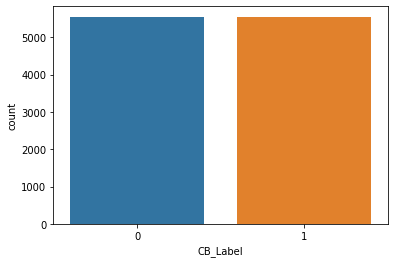

In [7]:
import seaborn as sns
sns.countplot(x="CB_Label", data = df)

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, callbacks
from tensorflow.keras import Model, Sequential

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import re
import string

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
import os
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.layers import LSTM


from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [10]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [39]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(d, 3))
    recall.append(round(c, 3))
    f1score.append(round(b, 3))

In [11]:
import collections
import nltk
from sklearn import preprocessing
from nltk.tokenize import sent_tokenize, word_tokenize
from tensorflow.keras import regularizers

In [12]:
#Setting parameters which will be used throughout
num_words = 15000  # Parameter indicating the number of words we'll put in the dictionary
val_size = 1000  # Size of the validation set
epochs = 20  # Number of epochs we usually start to train with
batch_size = 128  # Size of the batches used in the mini-batch gradient descent
#Taking only two columns since it's a sentiment analysis

In [13]:
#tweets conssits of every document as an array of tokenized words which are later appended to docs 
tweets=[word_tokenize(tweet) for tweet in df['Text']]
docs=[]
for j in range(0,len(tweets)):
    docs.append(tweets[j])

In [14]:
#stops included both the stopwords and punctuations
from nltk.corpus import stopwords
import string
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
not_list = ["n't", "not", "no"]
stops.update(punctuations)
stops.update(not_list)

In [15]:
#to get the simple pos(part of speech) tag
from nltk.corpus import wordnet
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
#to get the pos tag for a word
from nltk import pos_tag
# now we are going to clean our data 
# we will remove stopwords and punctuations and lemmatize each document
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
def clean(words):
    output=[]
    for word in words:
        if word.lower() not in stops or word.lower() in not_list:
            pos=pos_tag(word)
            clean_word=lemmatizer.lemmatize(word,pos=get_simple_pos(pos[0][1]))
            output.append(clean_word.lower())
    str1=" ".join(output).encode('utf-8')        
    return str1
#docs=[ clean(doc) for doc in docs]      

In [17]:
#taking only two columns in the dataframe
df=df[['Text','CB_Label']]
df.head()

Text  CB_Label
0  damn there is someones nana up here at beach w...         0
1  no kidding! dick clark was a corpse mechanical...         0
2  i read an article on jobros and thought damn w...         0
3  I got one fucking day of sprinkles and now it'...         0
4  I was already listening to Elliott smith  and ...         0

In [18]:
#taking variables to be used for train test split as X,y
X,Y=df['Text'].values,pd.get_dummies(df['CB_Label'].values)

In [19]:
#using tokenizers to create the tokens having no of words=15000(num_words)
tk = Tokenizer(num_words=num_words,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
#Complete data is tokenized to vectors and padding is done using zeros to match its length to the largest text in the dataset.
tk.fit_on_texts(X)
X = tk.texts_to_sequences(X)
X = pad_sequences(X)
#print(X[:2])
print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 11100 documents
15000 words in dictionary
Top 5 most common words are: [('you', 6552), ('i', 5513), ('the', 4562), ('a', 4331), ('to', 3826)]


In [20]:
import pickle
pickle.dump(tk,open('transform2.pkl','wb'))
#files.download('transform2.pkl')

In [21]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
print('# Train data samples:', X_train.shape)
print('# Test data samples:', X_test.shape)

# Train data samples: (8880, 705)
# Test data samples: (2220, 705)


# LSTM 

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding

In [26]:
embed_dim = 128 #dimension of the word embedding vector for each word in a sequence 
lstm_out = 196  #no of lstm layers
lstm_model = Sequential()
lstm_model.add(Embedding(num_words, embed_dim,input_length = X_train.shape[1]))
#Adding dropout
lstm_model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
#Adding a regularized dense layer
lstm_model.add(layers.Dense(32,kernel_regularizer=regularizers.l2(0.001),activation='relu'))
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(Dense(2,activation='softmax'))
lstm_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy',f1_m,precision_m, recall_m])


In [27]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 705, 128)          1920000   
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 32)                6304      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 2,181,170
Trainable params: 2,181,170
Non-trainable params: 0
_________________________________________________________________


In [28]:
#model trained on the training data and taking validation data into account to avoid overfitting for 4 epochs 
history1 =lstm_model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size,validation_data=(X_test, Y_test),verbose = 1)

Epoch 1/10
70/70 [==============================] - 295s 4s/step - loss: 0.7307 - accuracy: 0.6273 - f1_m: 0.6272 - precision_m: 0.6272 - recall_m: 0.6272 - val_loss: 0.6460 - val_accuracy: 0.7176 - val_f1_m: 0.7163 - val_precision_m: 0.7163 - val_recall_m: 0.7163
Epoch 2/10
70/70 [==============================] - 290s 4s/step - loss: 0.5709 - accuracy: 0.7459 - f1_m: 0.7464 - precision_m: 0.7464 - recall_m: 0.7464 - val_loss: 0.5391 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 3/10
70/70 [==============================] - 284s 4s/step - loss: 0.4185 - accuracy: 0.8359 - f1_m: 0.8361 - precision_m: 0.8361 - recall_m: 0.8361 - val_loss: 0.5687 - val_accuracy: 0.7234 - val_f1_m: 0.7236 - val_precision_m: 0.7236 - val_recall_m: 0.7236
Epoch 4/10
70/70 [==============================] - 291s 4s/step - loss: 0.2976 - accuracy: 0.9023 - f1_m: 0.9024 - precision_m: 0.9024 - recall_m: 0.9024 - val_loss: 0.6314 - val_accuracy: 0.7144 - val_f1

In [40]:
lstm_acc = history1.history['val_accuracy'][9]
lstm_prec = history1.history['val_precision_m'][9]
lstm_rec = history1.history['val_recall_m'][9]
lstm_f1 = history1.history['val_f1_m'][9]

In [41]:
storeResults('LSTM',lstm_acc,lstm_prec,lstm_rec,lstm_f1)

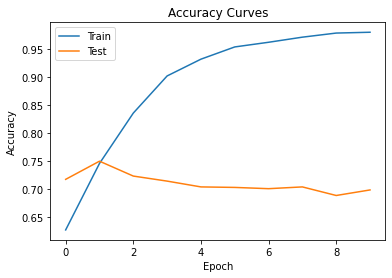

In [29]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

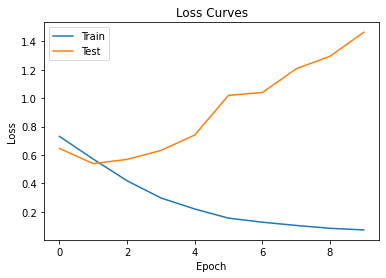

In [30]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# LSTM + GRU

In [31]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

In [32]:
embed_dim = 128 

In [33]:
model_hy=tf.keras.Sequential()

model_hy.add(tf.keras.layers.Input(shape=[100]))
model_hy.add(tf.keras.layers.Embedding(num_words,embed_dim,input_length=X_train.shape[1]))    

model_hy.add(tf.keras.layers.LSTM(200, return_sequences=True))
model_hy.add(tf.keras.layers.Dropout(0.5))

model_hy.add(tf.keras.layers.LSTM(200,return_sequences=True))
model_hy.add(tf.keras.layers.Dropout(0.5))

model_hy.add(tf.keras.layers.GRU(200))
model_hy.add(tf.keras.layers.Dropout(0.5))
          
model_hy.add(tf.keras.layers.Dense(256))
model_hy.add(tf.keras.layers.Dropout(0.5))

model_hy.add(tf.keras.layers.Dense(2,activation='sigmoid')) #output layer


In [34]:
model_hy.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 128)          1920000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 200)          263200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 200)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 200)          320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 200)          0         
_________________________________________________________________
gru (GRU)                    (None, 200)               241200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)              

In [35]:
model_hy.compile(loss='categorical_crossentropy',optimizer='adam',metrics = ['accuracy',f1_m,precision_m, recall_m])

In [36]:
trained5 = model_hy.fit(X_train, Y_train, epochs = 10, batch_size=batch_size,validation_data=(X_test, Y_test),verbose = 1)

Epoch 1/10
70/70 [==============================] - 20s 241ms/step - loss: 0.6232 - accuracy: 0.6319 - f1_m: 0.6298 - precision_m: 0.6315 - recall_m: 0.6286 - val_loss: 0.4582 - val_accuracy: 0.7928 - val_f1_m: 0.7925 - val_precision_m: 0.7938 - val_recall_m: 0.7913
Epoch 2/10
70/70 [==============================] - 16s 231ms/step - loss: 0.4489 - accuracy: 0.7952 - f1_m: 0.7949 - precision_m: 0.7934 - recall_m: 0.7964 - val_loss: 3.3506 - val_accuracy: 0.5020 - val_f1_m: 0.5016 - val_precision_m: 0.5016 - val_recall_m: 0.5016
Epoch 3/10
70/70 [==============================] - 16s 236ms/step - loss: 0.4046 - accuracy: 0.8471 - f1_m: 0.8478 - precision_m: 0.8457 - recall_m: 0.8500 - val_loss: 0.2016 - val_accuracy: 0.9325 - val_f1_m: 0.9326 - val_precision_m: 0.9321 - val_recall_m: 0.9331
Epoch 4/10
70/70 [==============================] - 16s 232ms/step - loss: 0.2133 - accuracy: 0.9199 - f1_m: 0.9194 - precision_m: 0.9173 - recall_m: 0.9215 - val_loss: 0.1144 - val_accuracy: 0.9633 

In [42]:
hyd_acc = trained5.history['val_accuracy'][9]
hyd_prec = trained5.history['val_precision_m'][9]
hyd_rec = trained5.history['val_recall_m'][9]
hyd_f1 = trained5.history['val_f1_m'][9]

In [43]:
storeResults('LSTM+GRU Ensemble Model',hyd_acc,hyd_prec,hyd_rec,hyd_f1)

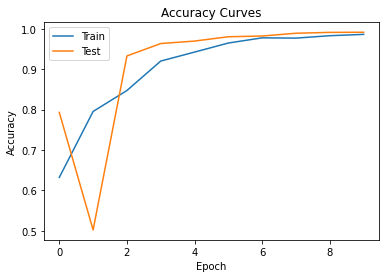

In [37]:
plt.plot(trained5.history['accuracy'])
plt.plot(trained5.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

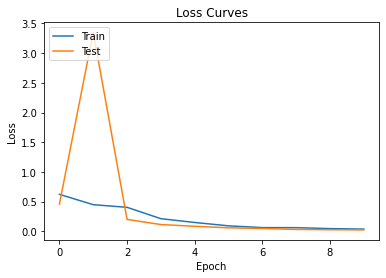

In [38]:
plt.plot(trained5.history['loss'])
plt.plot(trained5.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

ML

In [44]:
df.head()

Text  CB_Label
0  damn there is someones nana up here at beach w...         0
1  no kidding! dick clark was a corpse mechanical...         0
2  i read an article on jobros and thought damn w...         0
3  I got one fucking day of sprinkles and now it'...         0
4  I was already listening to Elliott smith  and ...         0

In [45]:
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import string 
from nltk.stem import WordNetLemmatizer

In [46]:
Tweet = []
Labels = []

for row in df["Text"]:
    #tokenize words
    words = word_tokenize(row)
    #remove punctuations
    clean_words = [word.lower() for word in words if word not in set(string.punctuation)]
    #remove stop words
    english_stops = set(stopwords.words('english'))
    characters_to_remove = ["''",'``',"rt","https","’","“","”","\u200b","--","n't","'s","...","//t.c" ]
    clean_words = [word for word in clean_words if word not in english_stops]
    clean_words = [word for word in clean_words if word not in set(characters_to_remove)]
    #Lematise words
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma_list = [wordnet_lemmatizer.lemmatize(word) for word in clean_words]
    Tweet.append(lemma_list)

In [47]:
X = df['Text']
y = df['CB_Label']

In [48]:
# Extract Feature With CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(X) # Fit the Data

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=0)
LR.fit(X_train, y_train) 
y_pred = LR.predict(X_test)

logr_acc = accuracy_score(y_test, y_pred)
logr_prec = precision_score(y_test, y_pred,average='weighted')
logr_rec = recall_score(y_test, y_pred,average='weighted')
logr_f1 = f1_score(y_test, y_pred,average='weighted')

In [52]:
storeResults('Logistic Regression',logr_acc,logr_prec,logr_rec,logr_f1)

# LinearSVC

In [54]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train, y_train) 
y_pred = svc.predict(X_test)

svc_acc = accuracy_score(y_test, y_pred)
svc_prec = precision_score(y_test, y_pred,average='weighted')
svc_rec = recall_score(y_test, y_pred,average='weighted')
svc_f1 = f1_score(y_test, y_pred,average='weighted')

In [55]:
storeResults('LinearSVC',svc_acc,svc_prec,svc_rec,svc_f1)

# Voting CLassifier

In [56]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
clf1 = AdaBoostClassifier(n_estimators=100, random_state=0)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)

eclf = VotingClassifier(estimators=[('ad', clf1), ('rf', clf2)], voting='soft')
eclf.fit(X_train, y_train)

y_pred = eclf.predict(X_test)

vot_acc = accuracy_score(y_pred, y_test)
vot_prec = precision_score(y_pred, y_test,average='weighted')
vot_rec = recall_score(y_pred, y_test,average='weighted')
vot_f1 = f1_score(y_pred, y_test,average='weighted')

In [57]:
storeResults('Voting Classifier',vot_acc,vot_prec,vot_rec,vot_f1)

TL

In [58]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import regex as re
import transformers
#import keras
from tensorflow.keras import backend as K
import plotly.express as px

In [59]:
df.head()

Text  CB_Label
0  damn there is someones nana up here at beach w...         0
1  no kidding! dick clark was a corpse mechanical...         0
2  i read an article on jobros and thought damn w...         0
3  I got one fucking day of sprinkles and now it'...         0
4  I was already listening to Elliott smith  and ...         0

In [63]:
def clean_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.Text):
        sentence=sentence.lower()
        
        #removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
        #removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text

In [64]:
df.Text = clean_text(df)
df

  0%|          | 0/11100 [00:00<?, ?it/s]

Text  CB_Label
0      damn there is someones nana up here at beach w...         0
1      no kidding  dick clark was a corpse mechanical...         0
2      i read an article on jobros and thought damn w...         0
3      i got one fucking day of sprinkles and now it ...         0
4      i was already listening to elliott smith  and ...         0
...                                                  ...       ...
11095   don t worry you little empty head over it    ...         1
11096   some of ya ll are dumb as fuck     these are ...         1
11097   lana  you re so full of shit your eyes are br...         1
11098   you ain t lying let the  dbeeio61 disqus xa0 ...         1
11099   looks like that little cut n paste job has go...         1

[11100 rows x 2 columns]

In [65]:
#Split dataset
from sklearn.model_selection import train_test_split

posts = df['Text'].values
labels =  df['CB_Label'].values
train_data, test_data = train_test_split(df, random_state=0, test_size=0.2)

train_size = len(train_data)
test_size = len(test_data)
train_size, test_size

(8880, 2220)

# DistiBERT

In [66]:
from transformers import AutoTokenizer, TFDistilBertModel

In [67]:
from transformers import DistilBertTokenizer

In [68]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
MAX_LEN = 128

In [69]:
def tokenize_sentences(sentences, tokenizer, max_seq_len = 1800):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)
        
    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

train_input_ids = tokenize_sentences(train_data['Text'], tokenizer, MAX_LEN)
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
train_attention_masks = create_attention_masks(train_input_ids)

test_input_ids = tokenize_sentences(test_data['Text'], tokenizer, MAX_LEN)
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
test_attention_masks = create_attention_masks(test_input_ids)

  0%|          | 0/8880 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/2220 [00:00<?, ?it/s]

In [70]:
BATCH_SIZE=32 
NR_EPOCHS=10

In [81]:
tf.config.run_functions_eagerly(True)

In [82]:
def create_model(): 
    input_word_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32,
                                           name="input_word_ids")
    bert_layer = transformers.TFDistilBertModel.from_pretrained("distilbert-base-uncased")
    bert_outputs = bert_layer(input_word_ids)[0]
    pred = tf.keras.layers.Dense(2, activation='softmax')(bert_outputs[:,0,:])
    
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00002), metrics=['accuracy', f1_m, precision_m, recall_m])
    return model

In [83]:
model_distlbert = create_model()
    
model_distlbert.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_distil_bert_model_2 (TFDi TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 768)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 1538      
Total params: 66,364,418
Trainable params: 66,364,418
Non-trainable params: 0
_________________________________________________________________


In [84]:
types = np.unique(df.CB_Label.values)

def get_type_index(string):
    return list(types).index(string)

In [85]:
train_data['type_index'] = df['CB_Label'].apply(get_type_index)

In [86]:
one_hot_labels = tf.keras.utils.to_categorical(train_data.type_index.values, num_classes=2)

In [87]:
hist3 = model_distlbert.fit(np.array(train_input_ids), one_hot_labels, verbose = 1, epochs = NR_EPOCHS, batch_size = BATCH_SIZE, validation_split=0.25)

Epoch 1/10
209/209 [==============================] - 29s 138ms/step - loss: 0.5646 - accuracy: 0.6931 - f1_m: 0.6944 - precision_m: 0.6944 - recall_m: 0.6944 - val_loss: 0.4891 - val_accuracy: 0.7550 - val_f1_m: 0.7557 - val_precision_m: 0.7557 - val_recall_m: 0.7557
Epoch 2/10
209/209 [==============================] - 29s 139ms/step - loss: 0.4448 - accuracy: 0.7868 - f1_m: 0.7877 - precision_m: 0.7877 - recall_m: 0.7877 - val_loss: 0.4908 - val_accuracy: 0.7662 - val_f1_m: 0.7668 - val_precision_m: 0.7668 - val_recall_m: 0.7668
Epoch 3/10
209/209 [==============================] - 29s 137ms/step - loss: 0.3545 - accuracy: 0.8350 - f1_m: 0.8357 - precision_m: 0.8357 - recall_m: 0.8357 - val_loss: 0.5120 - val_accuracy: 0.7613 - val_f1_m: 0.7604 - val_precision_m: 0.7604 - val_recall_m: 0.7604
Epoch 4/10
209/209 [==============================] - 29s 137ms/step - loss: 0.2189 - accuracy: 0.9113 - f1_m: 0.9106 - precision_m: 0.9106 - recall_m: 0.9106 - val_loss: 0.7477 - val_accuracy:

In [88]:
distlbert_acc = hist3.history['val_accuracy'][9]
distlbert_prec = hist3.history['val_precision_m'][9]
distlbert_rec = hist3.history['val_recall_m'][9]
distlbert_f1 = hist3.history['val_f1_m'][9]

In [89]:
storeResults('DistilBERT',distlbert_acc,distlbert_prec,distlbert_rec,distlbert_f1)

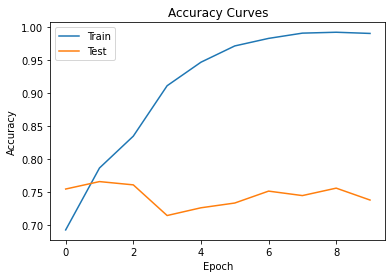

In [90]:
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

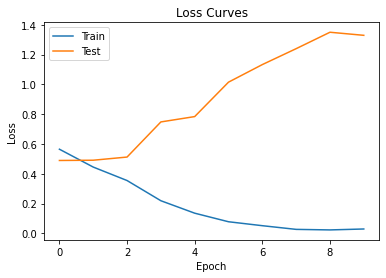

In [91]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# DistiRoBERT

In [92]:
from transformers import RobertaTokenizer, TFRobertaModel

In [93]:
tokenizer = RobertaTokenizer.from_pretrained("distilroberta-base")

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

In [94]:
def tokenize_sentences(sentences, tokenizer, max_seq_len = 1800):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)
        
    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

train_input_ids = tokenize_sentences(train_data['Text'], tokenizer, MAX_LEN)
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
train_attention_masks = create_attention_masks(train_input_ids)

test_input_ids = tokenize_sentences(test_data['Text'], tokenizer, MAX_LEN)
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
test_attention_masks = create_attention_masks(test_input_ids)

  0%|          | 0/8880 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/2220 [00:00<?, ?it/s]

In [99]:
tf.config.run_functions_eagerly(True)

In [100]:
def create_model(): 
    input_word_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32,
                                           name="input_word_ids")
    bert_layer = TFRobertaModel.from_pretrained("distilroberta-base")
    bert_outputs = bert_layer(input_word_ids)[0]
    pred = tf.keras.layers.Dense(2, activation='softmax')(bert_outputs[:,0,:])
    
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00002), metrics=['accuracy', f1_m, precision_m, recall_m])
    return model

In [101]:
model_robert = create_model()
    
model_robert.summary()

Some layers from the model checkpoint at distilroberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_roberta_model_1 (TFRobert TFBaseModelOutputWithPool 82118400  
_________________________________________________________________
tf.__operators__.getitem_4 ( (None, 768)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 1538      
Total params: 82,119,938
Trainable params: 82,119,938
Non-trainable params: 0
_________________________________________________________________


In [102]:
types = np.unique(df.CB_Label.values)

def get_type_index(string):
    return list(types).index(string)

In [103]:
train_data['type_index'] = df['CB_Label'].apply(get_type_index)
train_data

Text  CB_Label  type_index
3192   good to hear your okay    i need my the gay   ...         0           0
5422                                          lol you            0           0
2280   do you keep getting the one with the wheel tha...         0           0
3341                 thats what you get for being fat            0           0
4085                        favourite movie of all time          0           0
...                                                  ...       ...         ...
4859                             not that i can think of         0           0
3264   though i don t have a whole lotta love for ms ...         0           0
9845    democrats hate success   xa0 and commies like...         1           1
10799   anoel xa0 xa0   xa0 xa0 gotta go do  real  wo...         1           1
2732   oh no  that really sucks  randalls next time i...         0           0

[8880 rows x 3 columns]

In [106]:
one_hot_labels = tf.keras.utils.to_categorical(train_data.type_index.values, num_classes=2)

In [107]:
hist2 = model_robert.fit(np.array(train_input_ids), one_hot_labels, verbose = 1, epochs = NR_EPOCHS, batch_size = BATCH_SIZE, validation_split=0.25)

Epoch 1/10
 25/209 [==>...........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5263 - f1_m: 0.5262 - precision_m: 0.5263 - recall_m: 0.5263WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


 75/209 [=========>....................] - ETA: 17s - loss: 0.6767 - accuracy: 0.5608 - f1_m: 0.5608 - precision_m: 0.5608 - recall_m: 0.5608WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


125/209 [================>.............] - ETA: 10s - loss: 0.6715 - accuracy: 0.5615 - f1_m: 0.5615 - precision_m: 0.5615 - recall_m: 0.5615WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


175/209 [========================>.....] - ETA: 4s - loss: 0.6678 - accuracy: 0.5625 - f1_m: 0.5625 - precision_m: 0.5625 - recall_m: 0.5625WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


209/209 [==============================] - 30s 142ms/step - loss: 0.6570 - accuracy: 0.5841 - f1_m: 0.5837 - precision_m: 0.5837 - recall_m: 0.5837 - val_loss: 0.5563 - val_accuracy: 0.6995 - val_f1_m: 0.7007 - val_precision_m: 0.7007 - val_recall_m: 0.7007
Epoch 2/10
 16/209 [=>............................] - ETA: 24s - loss: 0.5341 - accuracy: 0.7344 - f1_m: 0.7344 - precision_m: 0.7344 - recall_m: 0.7344WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


 66/209 [========>.....................] - ETA: 18s - loss: 0.5314 - accuracy: 0.7292 - f1_m: 0.7292 - precision_m: 0.7292 - recall_m: 0.7292WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


116/209 [===============>..............] - ETA: 11s - loss: 0.5357 - accuracy: 0.7263 - f1_m: 0.7263 - precision_m: 0.7263 - recall_m: 0.7263WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


166/209 [======================>.......] - ETA: 5s - loss: 0.5266 - accuracy: 0.7346 - f1_m: 0.7346 - precision_m: 0.7346 - recall_m: 0.7346WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


209/209 [==============================] - 30s 142ms/step - loss: 0.5261 - accuracy: 0.7350 - f1_m: 0.7350 - precision_m: 0.7350 - recall_m: 0.7350 - val_loss: 0.4922 - val_accuracy: 0.7518 - val_f1_m: 0.7525 - val_precision_m: 0.7525 - val_recall_m: 0.7525
Epoch 3/10
  7/209 [>.............................] - ETA: 25s - loss: 0.5237 - accuracy: 0.7321 - f1_m: 0.7321 - precision_m: 0.7321 - recall_m: 0.7321WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


 57/209 [=======>......................] - ETA: 19s - loss: 0.4848 - accuracy: 0.7626 - f1_m: 0.7626 - precision_m: 0.7626 - recall_m: 0.7626WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


107/209 [==============>...............] - ETA: 12s - loss: 0.4645 - accuracy: 0.7801 - f1_m: 0.7801 - precision_m: 0.7801 - recall_m: 0.7801WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


157/209 [=====================>........] - ETA: 6s - loss: 0.4652 - accuracy: 0.7753 - f1_m: 0.7753 - precision_m: 0.7753 - recall_m: 0.7753WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


207/209 [============================>.] - ETA: 0s - loss: 0.4608 - accuracy: 0.7784 - f1_m: 0.7784 - precision_m: 0.7784 - recall_m: 0.7784WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


209/209 [==============================] - 30s 142ms/step - loss: 0.4608 - accuracy: 0.7784 - f1_m: 0.7783 - precision_m: 0.7783 - recall_m: 0.7783 - val_loss: 0.4917 - val_accuracy: 0.7698 - val_f1_m: 0.7704 - val_precision_m: 0.7704 - val_recall_m: 0.7704
Epoch 4/10
 23/209 [==>...........................] - ETA: 23s - loss: 0.4147 - accuracy: 0.8043 - f1_m: 0.8043 - precision_m: 0.8043 - recall_m: 0.8043WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


 73/209 [=========>....................] - ETA: 17s - loss: 0.4284 - accuracy: 0.7992 - f1_m: 0.7992 - precision_m: 0.7992 - recall_m: 0.7992WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


123/209 [================>.............] - ETA: 10s - loss: 0.4164 - accuracy: 0.8110 - f1_m: 0.8110 - precision_m: 0.8110 - recall_m: 0.8110WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


173/209 [=======================>......] - ETA: 4s - loss: 0.4119 - accuracy: 0.8127 - f1_m: 0.8127 - precision_m: 0.8127 - recall_m: 0.8127WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


209/209 [==============================] - 30s 142ms/step - loss: 0.4118 - accuracy: 0.8126 - f1_m: 0.8134 - precision_m: 0.8134 - recall_m: 0.8134 - val_loss: 0.4726 - val_accuracy: 0.7775 - val_f1_m: 0.7780 - val_precision_m: 0.7780 - val_recall_m: 0.7780
Epoch 5/10
 14/209 [=>............................] - ETA: 24s - loss: 0.3808 - accuracy: 0.8214 - f1_m: 0.8214 - precision_m: 0.8214 - recall_m: 0.8214WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


 64/209 [========>.....................] - ETA: 18s - loss: 0.3521 - accuracy: 0.8403 - f1_m: 0.8403 - precision_m: 0.8403 - recall_m: 0.8403WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


114/209 [===============>..............] - ETA: 12s - loss: 0.3495 - accuracy: 0.8459 - f1_m: 0.8459 - precision_m: 0.8459 - recall_m: 0.8459WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


164/209 [======================>.......] - ETA: 5s - loss: 0.3579 - accuracy: 0.8415 - f1_m: 0.8415 - precision_m: 0.8415 - recall_m: 0.8415WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


209/209 [==============================] - 30s 142ms/step - loss: 0.3564 - accuracy: 0.8441 - f1_m: 0.8448 - precision_m: 0.8448 - recall_m: 0.8448 - val_loss: 0.5001 - val_accuracy: 0.7662 - val_f1_m: 0.7653 - val_precision_m: 0.7653 - val_recall_m: 0.7653
Epoch 6/10
  5/209 [..............................] - ETA: 26s - loss: 0.2857 - accuracy: 0.8938 - f1_m: 0.8937 - precision_m: 0.8938 - recall_m: 0.8938WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


 55/209 [======>.......................] - ETA: 20s - loss: 0.2869 - accuracy: 0.8784 - f1_m: 0.8784 - precision_m: 0.8784 - recall_m: 0.8784WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


105/209 [==============>...............] - ETA: 13s - loss: 0.2867 - accuracy: 0.8759 - f1_m: 0.8759 - precision_m: 0.8759 - recall_m: 0.8759WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


155/209 [=====================>........] - ETA: 7s - loss: 0.2880 - accuracy: 0.8744 - f1_m: 0.8744 - precision_m: 0.8744 - recall_m: 0.8744WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


205/209 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.8720 - f1_m: 0.8720 - precision_m: 0.8720 - recall_m: 0.8720WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


209/209 [==============================] - 30s 145ms/step - loss: 0.2979 - accuracy: 0.8710 - f1_m: 0.8695 - precision_m: 0.8695 - recall_m: 0.8695 - val_loss: 0.5315 - val_accuracy: 0.7644 - val_f1_m: 0.7643 - val_precision_m: 0.7643 - val_recall_m: 0.7643
Epoch 7/10
 21/209 [==>...........................] - ETA: 24s - loss: 0.2459 - accuracy: 0.8914 - f1_m: 0.8914 - precision_m: 0.8914 - recall_m: 0.8914WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


 71/209 [=========>....................] - ETA: 17s - loss: 0.2619 - accuracy: 0.8895 - f1_m: 0.8895 - precision_m: 0.8895 - recall_m: 0.8895WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


121/209 [================>.............] - ETA: 11s - loss: 0.2392 - accuracy: 0.9001 - f1_m: 0.9001 - precision_m: 0.9001 - recall_m: 0.9001WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


171/209 [=======================>......] - ETA: 4s - loss: 0.2401 - accuracy: 0.8997 - f1_m: 0.8997 - precision_m: 0.8997 - recall_m: 0.8997WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


209/209 [==============================] - 30s 142ms/step - loss: 0.2407 - accuracy: 0.8992 - f1_m: 0.8997 - precision_m: 0.8997 - recall_m: 0.8997 - val_loss: 0.5399 - val_accuracy: 0.7581 - val_f1_m: 0.7588 - val_precision_m: 0.7588 - val_recall_m: 0.7588
Epoch 8/10
 12/209 [>.............................] - ETA: 25s - loss: 0.1833 - accuracy: 0.9323 - f1_m: 0.9323 - precision_m: 0.9323 - recall_m: 0.9323WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


 62/209 [=======>......................] - ETA: 18s - loss: 0.1836 - accuracy: 0.9239 - f1_m: 0.9239 - precision_m: 0.9239 - recall_m: 0.9239WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


112/209 [===============>..............] - ETA: 12s - loss: 0.1868 - accuracy: 0.9202 - f1_m: 0.9202 - precision_m: 0.9202 - recall_m: 0.9202WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


162/209 [======================>.......] - ETA: 6s - loss: 0.1772 - accuracy: 0.9248 - f1_m: 0.9248 - precision_m: 0.9248 - recall_m: 0.9248WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


209/209 [==============================] - 30s 142ms/step - loss: 0.1823 - accuracy: 0.9224 - f1_m: 0.9227 - precision_m: 0.9227 - recall_m: 0.9227 - val_loss: 0.8189 - val_accuracy: 0.7617 - val_f1_m: 0.7624 - val_precision_m: 0.7624 - val_recall_m: 0.7624
Epoch 9/10
  3/209 [..............................] - ETA: 26s - loss: 0.0786 - accuracy: 0.9792 - f1_m: 0.9792 - precision_m: 0.9792 - recall_m: 0.9792WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


 53/209 [======>.......................] - ETA: 19s - loss: 0.1384 - accuracy: 0.9452 - f1_m: 0.9452 - precision_m: 0.9452 - recall_m: 0.9452WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


103/209 [=============>................] - ETA: 13s - loss: 0.1335 - accuracy: 0.9487 - f1_m: 0.9487 - precision_m: 0.9487 - recall_m: 0.9487WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


153/209 [====================>.........] - ETA: 7s - loss: 0.1338 - accuracy: 0.9483 - f1_m: 0.9483 - precision_m: 0.9483 - recall_m: 0.9483WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


203/209 [============================>.] - ETA: 0s - loss: 0.1366 - accuracy: 0.9461 - f1_m: 0.9461 - precision_m: 0.9461 - recall_m: 0.9461WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


209/209 [==============================] - 30s 142ms/step - loss: 0.1354 - accuracy: 0.9464 - f1_m: 0.9466 - precision_m: 0.9466 - recall_m: 0.9466 - val_loss: 1.0037 - val_accuracy: 0.7725 - val_f1_m: 0.7716 - val_precision_m: 0.7716 - val_recall_m: 0.7716
Epoch 10/10
 19/209 [=>............................] - ETA: 24s - loss: 0.1008 - accuracy: 0.9753 - f1_m: 0.9753 - precision_m: 0.9753 - recall_m: 0.9753WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


 69/209 [========>.....................] - ETA: 17s - loss: 0.1182 - accuracy: 0.9588 - f1_m: 0.9588 - precision_m: 0.9588 - recall_m: 0.9588WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


119/209 [================>.............] - ETA: 11s - loss: 0.1128 - accuracy: 0.9606 - f1_m: 0.9606 - precision_m: 0.9606 - recall_m: 0.9606WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


169/209 [=======================>......] - ETA: 5s - loss: 0.1126 - accuracy: 0.9578 - f1_m: 0.9578 - precision_m: 0.9578 - recall_m: 0.9578WARNING:tensorflow:Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss.


209/209 [==============================] - 30s 143ms/step - loss: 0.1137 - accuracy: 0.9575 - f1_m: 0.9577 - precision_m: 0.9577 - recall_m: 0.9577 - val_loss: 0.9437 - val_accuracy: 0.7572 - val_f1_m: 0.7579 - val_precision_m: 0.7579 - val_recall_m: 0.7579


In [108]:
robert_acc = hist2.history['val_accuracy'][9]
robert_prec = hist2.history['val_precision_m'][9]
robert_rec = hist2.history['val_recall_m'][9]
robert_f1 = hist2.history['val_f1_m'][9]

In [109]:
storeResults('RoBERTa',robert_acc,robert_prec,robert_rec,robert_f1)

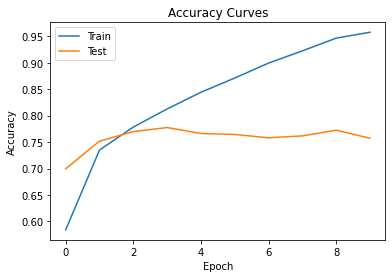

In [110]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

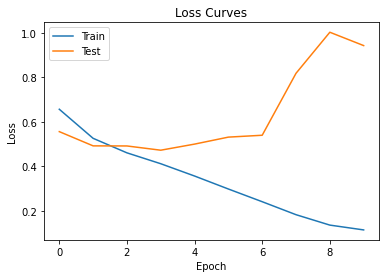

In [111]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Electra

In [112]:
from transformers import ElectraTokenizer, TFElectraModel

In [114]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [115]:
def tokenize_sentences(sentences, tokenizer, max_seq_len = 1800):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)
        
    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

train_input_ids = tokenize_sentences(train_data['Text'], tokenizer, MAX_LEN)
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
train_attention_masks = create_attention_masks(train_input_ids)

test_input_ids = tokenize_sentences(test_data['Text'], tokenizer, MAX_LEN)
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
test_attention_masks = create_attention_masks(test_input_ids)

  0%|          | 0/8880 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/2220 [00:00<?, ?it/s]

In [116]:
def create_model(): 
    input_word_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32,
                                           name="input_word_ids")
    bert_layer = TFElectraModel.from_pretrained("google/electra-small-discriminator")
    bert_outputs = bert_layer(input_word_ids)[0]
    pred = tf.keras.layers.Dense(2, activation='softmax')(bert_outputs[:,0,:])
    
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00002), metrics=['accuracy', f1_m, precision_m, recall_m])
    return model

In [117]:
model_electra = create_model()
    
model_electra.summary()

Downloading:   0%|          | 0.00/54.5M [00:00<?, ?B/s]

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-small-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_electra_model (TFElectraM TFBaseModelOutput(last_hi 13483008  
_________________________________________________________________
tf.__operators__.getitem_5 ( (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 514       
Total params: 13,483,522
Trainable params: 13,483,522
Non-trainable params: 0
_________________________________________________________________


In [118]:
types = np.unique(df.CB_Label.values)

def get_type_index(string):
    return list(types).index(string)

In [119]:
train_data['type_index'] = df['CB_Label'].apply(get_type_index)

In [121]:
one_hot_labels = tf.keras.utils.to_categorical(train_data.type_index.values, num_classes=2)

In [122]:
hist4 = model_electra.fit(np.array(train_input_ids), one_hot_labels, verbose = 1, epochs = NR_EPOCHS, batch_size = BATCH_SIZE, validation_split=0.25)

Epoch 1/10
209/209 [==============================] - 48s 231ms/step - loss: 0.6480 - accuracy: 0.6272 - f1_m: 0.6277 - precision_m: 0.6277 - recall_m: 0.6277 - val_loss: 0.5391 - val_accuracy: 0.7383 - val_f1_m: 0.7384 - val_precision_m: 0.7384 - val_recall_m: 0.7384
Epoch 2/10
209/209 [==============================] - 48s 231ms/step - loss: 0.5318 - accuracy: 0.7260 - f1_m: 0.7261 - precision_m: 0.7261 - recall_m: 0.7261 - val_loss: 0.5122 - val_accuracy: 0.7536 - val_f1_m: 0.7536 - val_precision_m: 0.7536 - val_recall_m: 0.7536
Epoch 3/10
209/209 [==============================] - 48s 230ms/step - loss: 0.4819 - accuracy: 0.7668 - f1_m: 0.7678 - precision_m: 0.7678 - recall_m: 0.7678 - val_loss: 0.4969 - val_accuracy: 0.7532 - val_f1_m: 0.7524 - val_precision_m: 0.7524 - val_recall_m: 0.7524
Epoch 4/10
209/209 [==============================] - 48s 231ms/step - loss: 0.4498 - accuracy: 0.7878 - f1_m: 0.7877 - precision_m: 0.7877 - recall_m: 0.7877 - val_loss: 0.4920 - val_accuracy:

In [123]:
ele_acc = hist4.history['val_accuracy'][9]
ele_prec = hist4.history['val_precision_m'][9]
ele_rec = hist4.history['val_recall_m'][9]
ele_f1 = hist4.history['val_f1_m'][9]

In [124]:
storeResults('Electra',ele_acc,ele_prec,ele_rec,ele_f1)

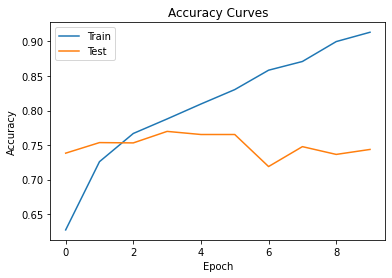

In [125]:
plt.plot(hist4.history['accuracy'])
plt.plot(hist4.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

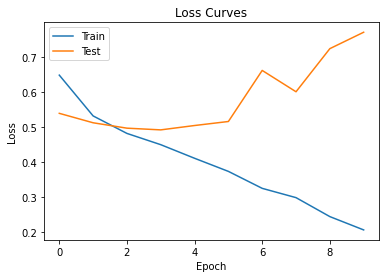

In [126]:
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Comparison

In [127]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                       'Precision': precision,
                       'Recall'   : recall,
                        'f1_score' : f1score,
                      })

In [128]:
result

ML Model  Accuracy  Precision  Recall  f1_score
0                     LSTM     0.699      0.698   0.698     0.698
1  LSTM+GRU Ensemble Model     0.991      0.991   0.991     0.991
2      Logistic Regression     0.744      0.743   0.744     0.746
3                LinearSVC     0.708      0.707   0.708     0.708
4        Voting Classifier     0.752      0.753   0.752     0.757
5               DistilBERT     0.738      0.738   0.738     0.738
6                  RoBERTa     0.757      0.758   0.758     0.758
7                  Electra     0.744      0.743   0.743     0.743

# Modelling

In [134]:
model_hy.save('model.h5')

# Graph

In [129]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

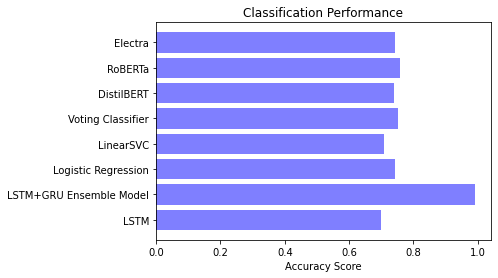

In [130]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

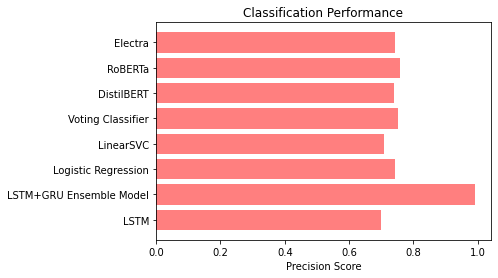

In [131]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

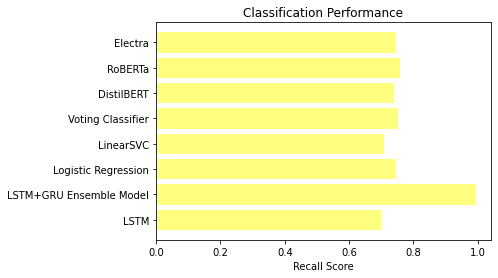

In [132]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='yellow')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

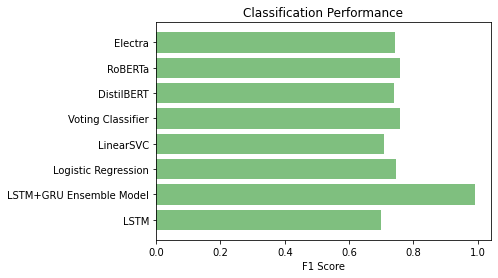

In [133]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='green')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()